# Convergence plot. Minimal BMN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rc("text", usetex=True)
plt.style.use("../figures/paper.mplstyle")

## Read data from disk

In [2]:
# parameters
opt_label = ["COBYLA","L-BFGS-B","SLSQP","NELDER-MEAD"]
var_label = 'ry'
coupling = '02'
depth = '3'
nrep = '10'
maxiter = '10000'

In [3]:
def read_data(optimizer):
    filename = f"../data/miniBMN_l{coupling}_convergence_{optimizer}_{var_label}_depth{depth}_reps{nrep}_max{maxiter}.h5"
    return pd.read_hdf(filename,"vqe")

In [4]:
df = read_data(opt_label[0])

In [5]:
df.head()

,counts,energy
rep,,
0,1,5.273152
0,2,6.173391
0,3,5.800338
0,4,5.254761
0,5,5.712117


In [6]:
best_values = df["energy"].groupby("rep").apply(min)

In [7]:
best_values.sort_values()

rep
5    0.125046
0    0.125059
7    0.125154
3    0.125154
2    0.125155
8    0.125155
9    0.125155
4    0.149428
6    0.150001
1    0.150003
Name: energy, dtype: float64

Collect multiple data in one frame

In [8]:
frames = [read_data(o) for o in opt_label]
result = pd.concat(frames, keys=opt_label,names=['Optimizer'])

In [9]:
result.head()

counts    energy
Optimizer rep                  
COBYLA    0         1  5.273152
          0         2  6.173391
          0         3  5.800338
          0         4  5.254761
          0         5  5.712117

<AxesSubplot:xlabel='counts'>

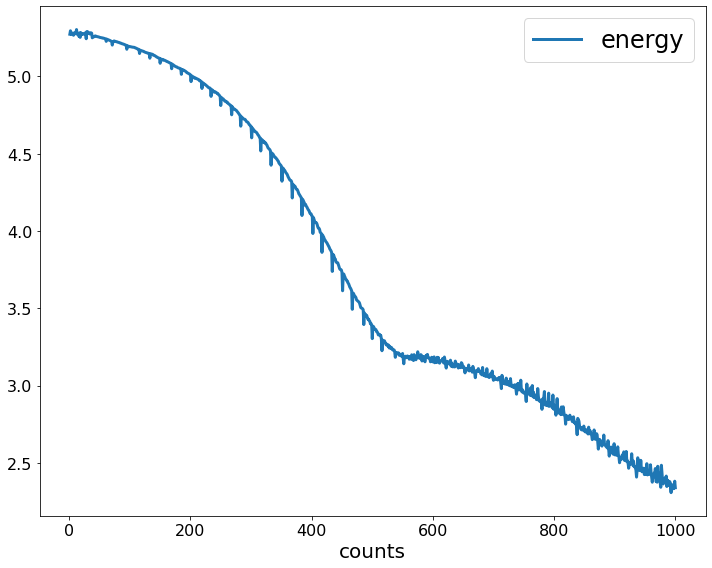

In [24]:
result.loc["NELDER-MEAD",0].plot(x='counts',y='energy')

## Get stats

In [10]:
result.groupby('Optimizer').apply(min).energy

Optimizer
COBYLA         0.125046
L-BFGS-B       0.125028
SLSQP          0.124945
NELDER-MEAD    1.538926
Name: energy, dtype: float64

In [11]:
result.loc["COBYLA"].groupby('rep').apply(min).energy

rep
0    0.125059
1    0.150003
2    0.125155
3    0.125154
4    0.149428
5    0.125046
6    0.150001
7    0.125154
8    0.125155
9    0.125155
Name: energy, dtype: float64

In [12]:
for r in opt_label:
    print("Optimizer:",r)
    print("Mean: ",result.loc[r].groupby('rep').apply(min).energy.mean())
    print("Std: ",result.loc[r].groupby('rep').apply(min).energy.std())
    print("Min: ",result.loc[r].groupby('rep').apply(min).energy.min())
    print("Max: ",result.loc[r].groupby('rep').apply(min).energy.max())

Optimizer: COBYLA
Mean:  0.1325311787900969
Std:  0.011925196099168138
Min:  0.12504608349862176
Max:  0.15000285392411333
Optimizer: L-BFGS-B
Mean:  0.14504139482648348
Std:  0.010462321591099864
Min:  0.125028492038143
Max:  0.15001831544646624
Optimizer: SLSQP
Mean:  0.14500601755174797
Std:  0.010529627297101475
Min:  0.12494519100652432
Max:  0.15000133323102485
Optimizer: NELDER-MEAD
Mean:  2.2852936545188305
Std:  0.5627565296655614
Min:  1.5389263112252967
Max:  3.1822643338084475


In [13]:
gs = dict()
for r in opt_label:
    gs[r] = result.loc[r].groupby('rep').apply(min).energy
gsdf = pd.DataFrame.from_dict(gs, dtype=float)

In [14]:
gsdf

,COBYLA,L-BFGS-B,SLSQP,NELDER-MEAD
rep,,,,
0,0.125059,0.150013,0.150000,2.307118
1,0.150003,0.150000,0.150001,2.826954
2,0.125155,0.125028,0.124945,2.202345
3,0.125154,0.150000,0.150001,1.699852
4,0.149428,0.150018,0.150001,3.182264
5,0.125046,0.150000,0.150001,1.801551
6,0.150001,0.125354,0.125110,1.912064
7,0.125154,0.150000,0.150001,2.423772
8,0.125155,0.150000,0.150000,2.958089


In [15]:
gsdf.describe().T[["min","max","mean","std"]]

,min,max,mean,std
COBYLA,0.125046,0.150003,0.132531,0.011925
L-BFGS-B,0.125028,0.150018,0.145041,0.010462
SLSQP,0.124945,0.150001,0.145006,0.010530
NELDER-MEAD,1.538926,3.182264,2.285294,0.562757


## Plot convergence

Text(0, 0.5, 'VQE energy')

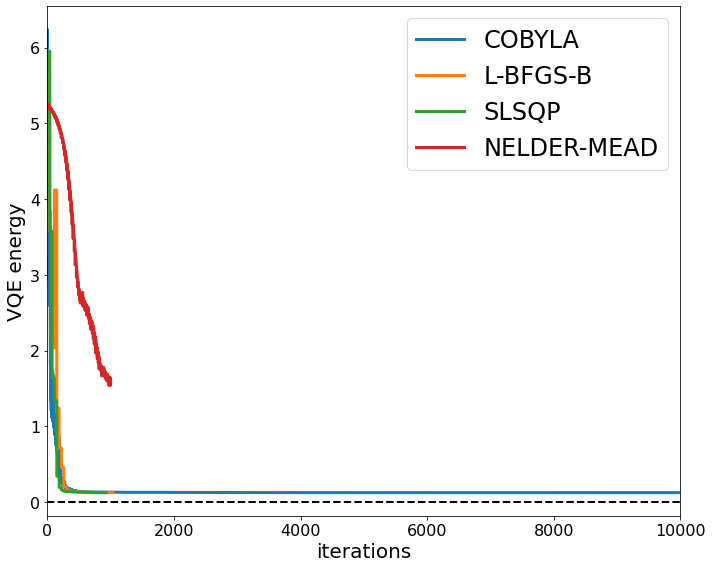

In [25]:
# select the best runs for each optimizer
fig, ax = plt.subplots()
for o in opt_label:
    result.loc[o,gsdf[o].idxmin()].plot(x='counts',y='energy', xlim=[0,10000],label=o, ax=ax)
ax.axhline(0,c="k",ls="--", lw="2",label="Exact")
ax.set_xlabel("iterations")
ax.set_ylabel("VQE energy")